## [Practical PyTorch: Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

In the last tutorial we used a RNN to classify names into their language of origin. This time we'll turn around and generate names from languages. This model will improve upon the RNN we used to generate Shakespeare one character at a time by adding another input (representing the language) so we can specify what kind of name to generate.
```
> python generate.py Russian
Rovakov
Uantov
Shavakov

> python generate.py German
Gerren
Ereng
Rosher

> python generate.py Spanish
Salla
Parer
Allan

> python generate.py Chinese
Chan
Hang
Iun
```
Being able to "prime" the generator with a specific category brings us a step closer to the Sequence to Sequence model used for machine translation.

## Preparing the Data
See Classifying Names with a Character-Level RNN for more detail - we're using the exact same dataset. In short, there are a bunch of plain text files data/names/[Language].txt with a name per line. We split lines into an array, convert Unicode to ASCII, and end up with a dictionary {language: [names ...]}.

In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii("O'Néàl"))

O'Neal


In [2]:
# Read a file and split into lines
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


## Creating the Network
This network extends the last tutorial's RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

![](c-rnn.png)

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, cat_size, input_size, hidden_size, output_size, dropout=0.1):
        super(RNN,self).__init__()
        self.cat_size = cat_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(cat_size+input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(cat_size+input_size+hidden_size, output_size)
        self.o2o = nn.Linear(output_size+hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, cat, input, hidden): # batch*d
        input_combined = torch.cat((cat, input, hidden),-1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((output, hidden),-1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1,self.hidden_size))

## Prepare for Training
For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD< EOS >" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

The category tensor is a one-hot tensor of size < 1 x n_categories >. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [4]:
import random

# Get a random category and random line from that category
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def random_training_example():
    category, line = random_training_pair()
    category_tensor = Variable(categoryTensor(category)) # 1, n_categories
    input_line_tensor = Variable(inputTensor(line)) # seq_len, 1, n_letters
    target_line_tensor = Variable(targetTensor(line)) # seq_len 
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [6]:
n_steps = 10000
print_every = 500
plot_every = 500
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

rnn = RNN(n_categories, n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

def train(cat_t, input_t, target_t):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(target_t.size()[0]):
        output, hidden = rnn(cat_t, input_t[i], hidden)
        loss += criterion(output, target_t[i])
        
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0] / target_t.size()[0]

In [7]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for step in range(1, n_steps + 1):
    output, loss = train(*random_training_example())
    loss_avg += loss
    
    if step % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), step, step / n_steps * 100, loss))

    if step % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 1s (500 5%) 3.4244
0m 3s (1000 10%) 2.8721
0m 5s (1500 15%) 2.8783
0m 7s (2000 20%) 2.6239
0m 9s (2500 25%) 2.6205
0m 11s (3000 30%) 2.6110
0m 13s (3500 35%) 2.5153
0m 14s (4000 40%) 1.8132
0m 16s (4500 45%) 2.6303
0m 18s (5000 50%) 3.1123
0m 20s (5500 55%) 2.0784
0m 22s (6000 60%) 1.7842
0m 24s (6500 65%) 2.1963
0m 26s (7000 70%) 2.4166
0m 27s (7500 75%) 1.2400
0m 29s (8000 80%) 2.3558
0m 31s (8500 85%) 2.0325
0m 33s (9000 90%) 3.4983
0m 35s (9500 95%) 2.9639
0m 37s (10000 100%) 1.5890


## Plotting the Network
Plotting the historical loss from all_losses shows the network learning:

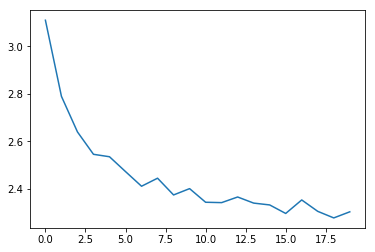

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Sampling the Network
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
- Create tensors for input category, starting letter, and empty hidden state
- Create a string output_str with the starting letter
- Up to a maximum output length,
    - Feed the current letter to the network
    - Get the next letter from highest output, and next hidden state
    - If the letter is EOS, stop here
    - If a regular letter, add to output_str and continue
- Return the final name

Note: Rather than supplying a starting letter every time we generate, we could have trained with a "start of string" token and had the network choose its own starting letter.

In [9]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.init_hidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        # sample from output distribution
        output_dist = torch.exp(output.data)
        topi = torch.multinomial(output_dist,1)
        # or greedy decode
#         topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

RhavitpimK
Uuvankye
Sustorky
Girbert
EpeKiften
RearR
Shachulotels
PeregarowFonelEs
Ariennarod
Chan
Hagg
Irbe
